170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 43s 0us/step


/Users/amusuokamoto/anaconda3/envs/dl/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.4398 - loss: 1.5500 - val_accuracy: 0.5560 - val_loss: 1.2917
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.5747 - loss: 1.2117 - val_accuracy: 0.5810 - val_loss: 1.1746
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.6222 - loss: 1.0776 - val_accuracy: 0.6424 - val_loss: 1.0330
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.6518 - loss: 0.9977 - val_accuracy: 0.6152 - val_loss: 1.0884
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.6754 - loss: 0.9363 - val_accuracy: 0.6448 - val_loss: 1.0350
Test accuracy: 0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


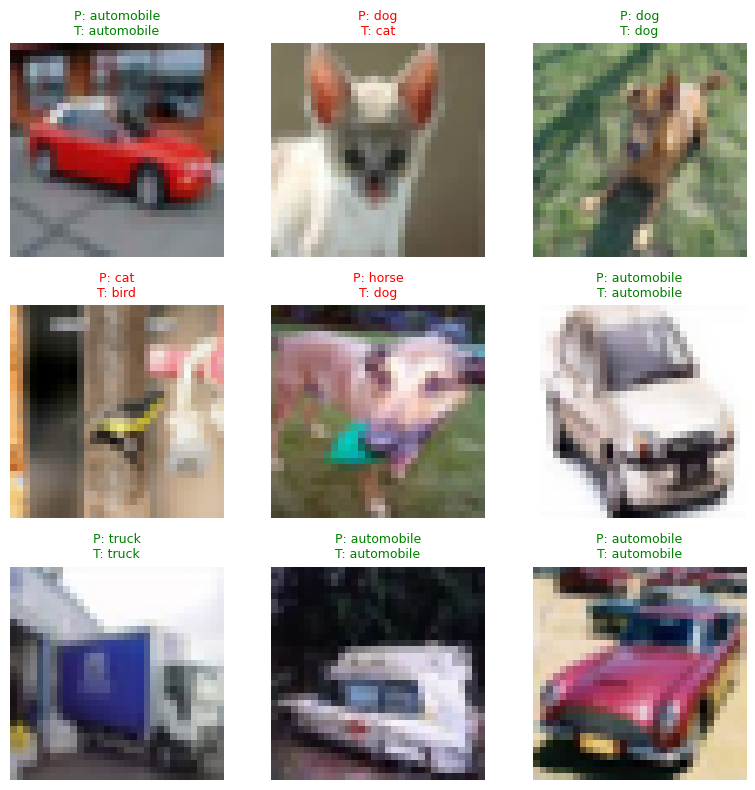

Afbeelding opgeslagen als cnn_cifar10_predictions.png


In [ ]:
# linkedin_cnn_demo.py
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

# 1. Data laden
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
class_names = ["airplane", "automobile", "bird", "cat", "deer",
               "dog", "frog", "horse", "ship", "truck"]

# 2. Klein CNN bouwen
model = keras.Sequential([
    layers.Conv2D(32, 3, activation="relu",input_shape=(32, 32, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(10, activation="softmax")
])

model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# 3. Trainen
history = model.fit(x_train, y_train, epochs=5,
                    validation_split=0.1, batch_size=64)

# 4. Evalueren
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.2f}")

# 5. Visualiseren – voorspellingen op 9 random plaatjes
indices = np.random.choice(len(x_test), 9, replace=False)
images, labels = x_test[indices], y_test[indices]
preds = model.predict(images)

plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    pred_label = class_names[np.argmax(preds[i])]
    true_label = class_names[labels[i][0]]
    color = "green" if pred_label == true_label else "red"
    plt.title(f"P: {pred_label}\nT: {true_label}", color=color, fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.savefig("cnn_cifar10_predictions.png", dpi=150)
plt.show()

print("Afbeelding opgeslagen als cnn_cifar10_predictions.png")


In [8]:
# -*- coding: utf-8 -*-
"""
CIFAR-10 CNN + LinkedIn GIF
- Traint een klein CNN
- Maakt na elke epoch een 3x3 grid met voorspellingen (groen/rood)
- Bouwt daar een GIF van
- Slaat ook training curves (accuracy/loss) op
"""

import os, time, numpy as np, matplotlib.pyplot as plt
from PIL import Image  # gebruiken voor GIF (stabiel i.c.m. NumPy 1.26)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ---------- 0) Setup ----------
SEED = 42
np.random.seed(SEED)
tf.keras.utils.set_random_seed(SEED)
os.makedirs("artifacts", exist_ok=True)

CLASS_NAMES = ["airplane","automobile","bird","cat","deer",
               "dog","frog","horse","ship","truck"]

# ---------- 1) Data ----------
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train = (x_train.astype("float32") / 255.0)
x_test  = (x_test.astype("float32")  / 255.0)
y_train = y_train.squeeze()
y_test  = y_test.squeeze()

# ---------- 2) Model ----------
def make_model():
    return keras.Sequential([
        layers.Input(shape=(32,32,3)),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Dropout(0.1),

        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),

        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(10, activation="softmax")
    ])

model = make_model()
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# ---------- 3) Handige helpers ----------
def plot_grid_frame(images, labels, probs, epoch, val_acc=None):
    """Maakt een 3x3 grid figure en retourneert een RGB numpy array (uint8)."""
    fig = plt.figure(figsize=(6,6))
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        ax.imshow(images[i])
        pred_idx = int(np.argmax(probs[i]))
        true_idx = int(labels[i])
        color = "green" if pred_idx == true_idx else "red"
        ax.set_title(f"P:{CLASS_NAMES[pred_idx]}\nT:{CLASS_NAMES[true_idx]}",
                     color=color, fontsize=9)
        ax.axis("off")

    title = f"Epoch {epoch}"
    if val_acc is not None:
        title += f" — Val Acc: {val_acc:.2%}"
    fig.suptitle(title, fontsize=14, y=0.99)
    plt.tight_layout(rect=[0,0,1,0.96])

    # Figure -> numpy uint8
    fig.canvas.draw()
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    return img

# ---------- 4) Train + frames verzamelen ----------
EPOCHS = 10
BATCH = 64
frames = []

# vaste (maar random gekozen) test-samples zodat je progress ziet
rng = np.random.default_rng(SEED)
sample_idx = rng.choice(len(x_test), size=9, replace=False)
sample_imgs = x_test[sample_idx]
sample_lbls = y_test[sample_idx]

history_acc, history_val_acc, history_loss, history_val_loss = [], [], [], []

for epoch in range(1, EPOCHS+1):
    h = model.fit(
        x_train, y_train,
        epochs=1, batch_size=BATCH,
        validation_split=0.1,
        verbose=0
    )
    history_acc.append(h.history["accuracy"][0])
    history_val_acc.append(h.history["val_accuracy"][0])
    history_loss.append(h.history["loss"][0])
    history_val_loss.append(h.history["val_loss"][0])

    # voorspellingen voor het frame
    probs = model.predict(sample_imgs, verbose=0)
    frame = plot_grid_frame(sample_imgs, sample_lbls, probs, epoch, history_val_acc[-1])
    frames.append(Image.fromarray(frame))

# ---------- 5) Opslaan: GIF + training curves ----------
gif_path = "artifacts/cnn_training.gif"
if frames:
    frames[0].save(
        gif_path,
        save_all=True,
        append_images=frames[1:],
        duration=900,  # ms per frame
        loop=0
    )
print(f"GIF opgeslagen: {gif_path}")

# Curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_acc, label="train")
plt.plot(history_val_acc, label="val")
plt.title("Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Acc"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history_loss, label="train")
plt.plot(history_val_loss, label="val")
plt.title("Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.tight_layout()
curves_path = "artifacts/cnn_training_curves.png"
plt.savefig(curves_path, dpi=150)
plt.close()
print(f"Curves opgeslagen: {curves_path}")

# ---------- 6) Testscore ----------
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.3f}")


/var/folders/sl/tynfs9b111n01s361s4jyykc0000gn/T/ipykernel_53944/937755696.py:81: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


GIF opgeslagen: artifacts/cnn_training.gif
Curves opgeslagen: artifacts/cnn_training_curves.png
Test accuracy: 0.730
